In [1]:
library(rstan)

Loading required package: StanHeaders




rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [2]:
## choose whatever is appropiate for your computing environment
## useful on laptop
cores <- parallel::detectCores()
## needed on cluster
#cores <- as.numeric(Sys.getenv("NSLOTS"))

In [3]:
options(mc.cores = cores)

In [4]:
expose_stan_functions('pkpd_mvn_approxb.stan')

In [5]:
valogit(50/100)

[1] 0

In [6]:
chains <- 4
iter <- 5000
warmup <- iter/2

___

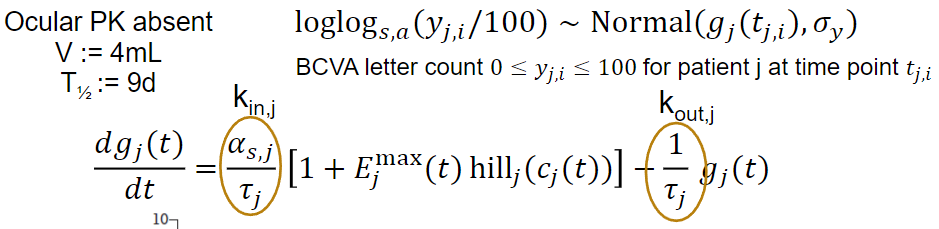

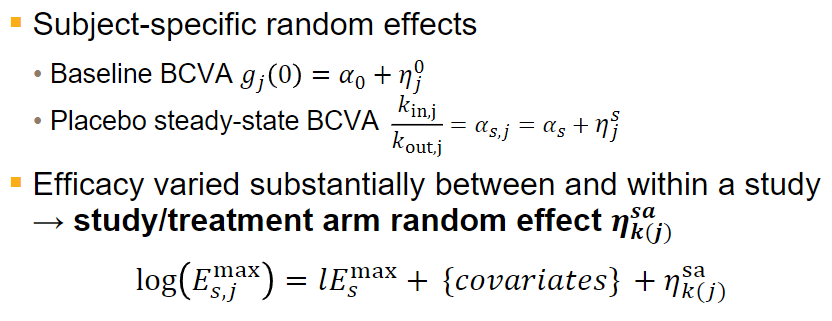

$\frac{dR_j(t)}{dt}=k^{in}_j-k^{out}_{j}[R_j(t)-E_{max_j}S_j(C_j(t))]$

$R^{SS}_j=(k^{in}_j/k^{out}_j)+E_{max_j}s_j$

Constant maximal drug effect means $S_j(t)=s_j=1$ for a patient in treatment group and o for placebo patients.
$R_j(t)=R^{ss}_j+(R_{0_j}-R^{ss}_jexp(-k^{out}_jt))$

$R_{0_j}\sim N(L\alpha_0, \sigma^2_{L\alpha_0})$
$L\alpha_0\sim N(0,2^2), \sigma_{L\alpha_0}\sim N^+(0,1^2)$

In [7]:
Lalpha_0 <- valogit(50/100)
sigma_Lalpha_0 <- 0.2
Lalpha_0

[1] 0

$L\alpha_s=\frac{\kappa^{in}_{j}}{\kappa^{out}_{j}}$ is the placebo steady state, the asymptotic value patients reach if not on treatment.

$L\alpha_s=logit(35/100)$

$L\alpha_s\sim N(-1, 2^2)$

In [8]:
Lalpha_s <- valogit(35/100)
Lalpha_s

[1] -0.6190392

$log(1/k^{out}_{j}) \sim N(l_\kappa, \sigma^2_{l_\kappa})$ detemines the patient specific time scale of the exponential change. $\kappa^{out}_j$ is a rate of change
$l_\kappa=log(10/52)$ and $l_\kappa\sim N(log(1/4), log(2)^2)$

$\sigma_{l_\kappa}\sim N^+(0, 1^2)$

In [9]:
lkappa <- log(10/52)
sigma_lkappa <- 0.5

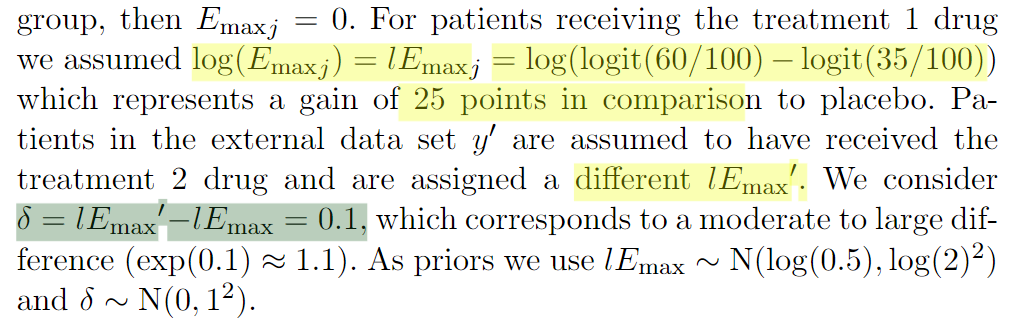

In [10]:
lEmax <- log(valogit(60/100)-Lalpha_s) # patients received treatment 1 with raw measurements data
lEmax

[1] 0.0242089

In [11]:
sigma_y <- 5/100 # measurement error

___

In [12]:
## from the first group the first half is placebo, the rest is on
## treatment 1
J <- 100

J_prime <- 100

In [13]:
## let's say we cover a year and measure monthly
x <- seq(0, 52, length=13) / 52
T <- 13

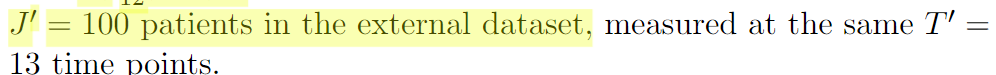

In [14]:
## for simplicity assume the prime data set is at the same time-points
x_prime <- seq(0, 52, length=13) / 52
T_prime <- 13

In [15]:
## number of simulations per draw of the posterior to get
## approximated log-lik weight
J_tilde <- 500

$\phi=\{\phi_1, \phi_2, \phi_3 \phi_4, \phi_5, \phi_6, \phi_7\} = \{L\alpha_0, L\alpha_s, l_\kappa, lEmax, log(\sigma_{L\alpha_0}), log(\sigma_{L\kappa}), log(\sigma_y) \}$

In [16]:
## define weakly-informative prior
## phi is ordered as:
##  phi[1] = Lalpha_0;
##  phi[2] = Lalpha_s;
##  phi[3] = lkappa;
##  phi[4] = lEmax;
##  phi[5] = log(sigma_Lalpha_0);
##  phi[6] = log(sigma_lkappa);
##  phi[7] = log(sigma_y);

$\mu_\phi$

In [17]:
mu_phi_p <- c(0, -1, log(1/4), log(0.5), 0, 0, 0)

In [18]:
K_phi <- length(mu_phi_p) # number of phis in the model

In [19]:
Sigma_phi_p <- diag(c(2, 2, log(2), log(2), 1, 1, 1)^2)

In [20]:
K <- 1
delta <- array(0.1, dim=1)
delta

[1] 0.1

In [21]:
mu_delta_p <- array(0, dim=1)
Sigma_delta_p <- matrix(1^2)

In [22]:
Sigma_delta_p

1


In [23]:
# simulated asymptotic values for each group
inv_valogit(Lalpha_s) ## placebo t=inf
inv_valogit(Lalpha_s + exp(lEmax)) ## drug=1 t=inf
inv_valogit(Lalpha_s + exp(lEmax + delta)) ## drug=2 t=inf

[1] 0.35

[1] 0.6

[1] 0.6255594

___

In [24]:
## simulate patient specific parameters
J_tot <- J + J_prime
subj_tot <- data.frame(id=1:J_tot
                      ,prime=rep(c(0,1), times=c(J, J_prime))
                      ,DRUG=0
                      ,eta_Lalpha_0=rnorm(J_tot, 0, 1)
                      ,eta_lkappa =rnorm(J_tot, 0, 1)
                   )

In [25]:
subj_tot$DRUG[(J/2+1):J] <- 1
subj_tot$DRUG[(J+1):J_tot] <- 2

In [26]:
subj       <- subset(subj_tot, prime==0)
subj_prime <- subset(subj_tot, prime==1)

In [27]:
source("utils_baad.R") # helper functions

### applies a function over each entry of the posterior if vectorized=FALSE; for vectorized=TRUE the function is assumed to perform the simulation in a single sweep. Note that all arguments to the function are automatically deduced from it's formals and that all arguments which are not in the sims list are searched in the global environment.

#### vapply() is used to apply a function to elements of a list, vector, or data frame. Unlike sapply or lapply, it requires you to specify the expected data type for the result.

In [28]:
asub() # subsetting
# asub(x, idx, dims = seq(along = dim(x)), drop = FALSE, ...)

ERROR: Error in asub(): could not find function "asub"


In [29]:
extract_draw <- function(sims, draw) lapply(sims, asub, idx=draw, dim=1)

In [30]:
NROW(subj[[1]])

[1] 100

In [31]:
pstream__ <- get_stream()

In [32]:
setdiff(names(formals(evaluate_model)), "seed")

[1] "x"              "DRUG"           "Lalpha_0"       "Lalpha_s"      
 [5] "lkappa"         "lEmax"          "delta"          "eta_Lalpha_0"  
 [9] "eta_lkappa"     "sigma_Lalpha_0" "sigma_lkappa"   "pstream__"

In [33]:
ysim       <- sim_posterior(subj, evaluate_model, TRUE)

In [34]:
dim(ysim)

[1] 100  13

In [35]:
ysim_prime <- sim_posterior(subj_prime, evaluate_model, TRUE)

In [36]:
dim(ysim_prime)

[1] 100  13

In [37]:
dimnames(ysim) <- list(id=1:J, k=1:T)

In [38]:
dim(ysim)

[1] 100  13

In [39]:
dimnames(ysim_prime) <- list(id=(1+J):J_tot, k=1:T_prime)

In [40]:
dimnames(ysim_prime)

$id
  [1] "101" "102" "103" "104" "105" "106" "107" "108" "109" "110" "111" "112"
 [13] "113" "114" "115" "116" "117" "118" "119" "120" "121" "122" "123" "124"
 [25] "125" "126" "127" "128" "129" "130" "131" "132" "133" "134" "135" "136"
 [37] "137" "138" "139" "140" "141" "142" "143" "144" "145" "146" "147" "148"
 [49] "149" "150" "151" "152" "153" "154" "155" "156" "157" "158" "159" "160"
 [61] "161" "162" "163" "164" "165" "166" "167" "168" "169" "170" "171" "172"
 [73] "173" "174" "175" "176" "177" "178" "179" "180" "181" "182" "183" "184"
 [85] "185" "186" "187" "188" "189" "190" "191" "192" "193" "194" "195" "196"
 [97] "197" "198" "199" "200"

$k
 [1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13"

In [42]:
library(abind)
library(reshape2)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘ggplot2’


The following object is masked from ‘package:dplyr’:

    vars




In [43]:
M <- arrange(melt(ysim), id, k)
Mp <- arrange(melt(ysim_prime), id, k)
M$x <- x[M$k]
Mp$x<- x_prime[Mp$k]

M <- merge(rbind(M,Mp), subj_tot, by="id")

In [44]:
dim(M)

[1] 2600    8

In [45]:
# ## look at the simulated means
plm <- ggplot(M, aes(x, value, group=id, colour=factor(DRUG))) +
        geom_line(alpha=0.3) +
        stat_summary(aes(group=DRUG), fun.data = "mean_cl_boot", position=position_dodge(width=0.02))


Warning message:
“Computation failed in `stat_summary()`.
Caused by error in `fun.data()`:
! The package "Hmisc" is required.”


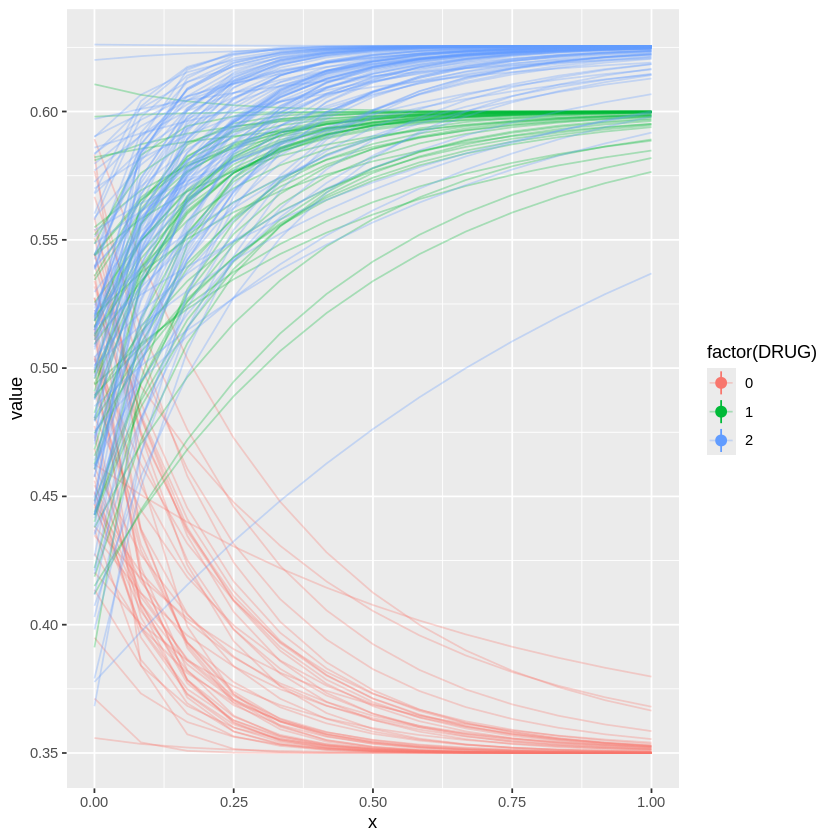

In [46]:
plm

In [47]:
## create noise which we recycle for all of the different delta
## simulations
y_err       <- matrix(rnorm(J*T,             0, sigma_y), J,       T)
y_prime_err <- matrix(rnorm(J_prime*T_prime, 0, sigma_y), J_prime, T_prime)
y           <- ysim       + y_err
y_prime <- ysim_prime + y_prime_err

In [48]:
y_prime_bar <- colMeans(y_prime)

In [49]:
length(y_prime_bar)

[1] 13

In [50]:
M_obs <- arrange(melt(y), id, k)
Mp_obs <- arrange(melt(y_prime), id, k)
M_obs$x <- x[M_obs$k]
Mp_obs$x<- x_prime[Mp_obs$k]

M_obs <- merge(rbind(M_obs,Mp_obs), subj_tot, by="id")

In [51]:
color_scale <- scale_colour_brewer(type="qual", palette=2)


The transform() function in R is a powerful tool for modifying data frames. It allows you to create new variables, modify existing ones, and even filter data all in one go. Here's a breakdown of what it does and how to use it:

In [52]:
M_obs <- transform(M_obs,
                   Data=factor(prime, levels=c(0,1), labels=c("Internal", "External")),
                   Treatment=factor(DRUG, levels=0:2, labels=c("Placebo", "Treatment 1", "Treatment 2"))
                   )

In [53]:
library(plyr)

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




In [54]:
M_obs_aggr <- ddply(M_obs, .(Data, Treatment, x), plyr::summarize, value=mean(value))

In [55]:
M_obs_aggr

Data,Treatment,x,value
<fct>,<fct>,<dbl>,<dbl>
Internal,Placebo,0.00000000,0.4844837
Internal,Placebo,0.08333333,0.4181016
Internal,Placebo,0.16666667,0.4068950
Internal,Placebo,0.25000000,0.3953976
Internal,Placebo,0.33333333,0.3787779
Internal,Placebo,0.41666667,0.3648630
Internal,Placebo,0.50000000,0.3629273
Internal,Placebo,0.58333333,0.3698712
Internal,Placebo,0.66666667,0.3512375


In [56]:
pl_obs <- ggplot(M_obs, aes(x, value, colour=Treatment)) +
    geom_line(alpha=0.4, aes(group=id)) + facet_grid(.~Data, labeller=label_both, drop=FALSE) +
        coord_cartesian(ylim=c(0.25,0.725)) + xlab("Time") +  ylab("Response") +
            ##stat_summary(aes(group=DRUG), fun.data = "mean_cl_boot", position=position_dodge(width=0.02)) +
                theme(legend.position=c(0.85, 0.25)) + color_scale

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


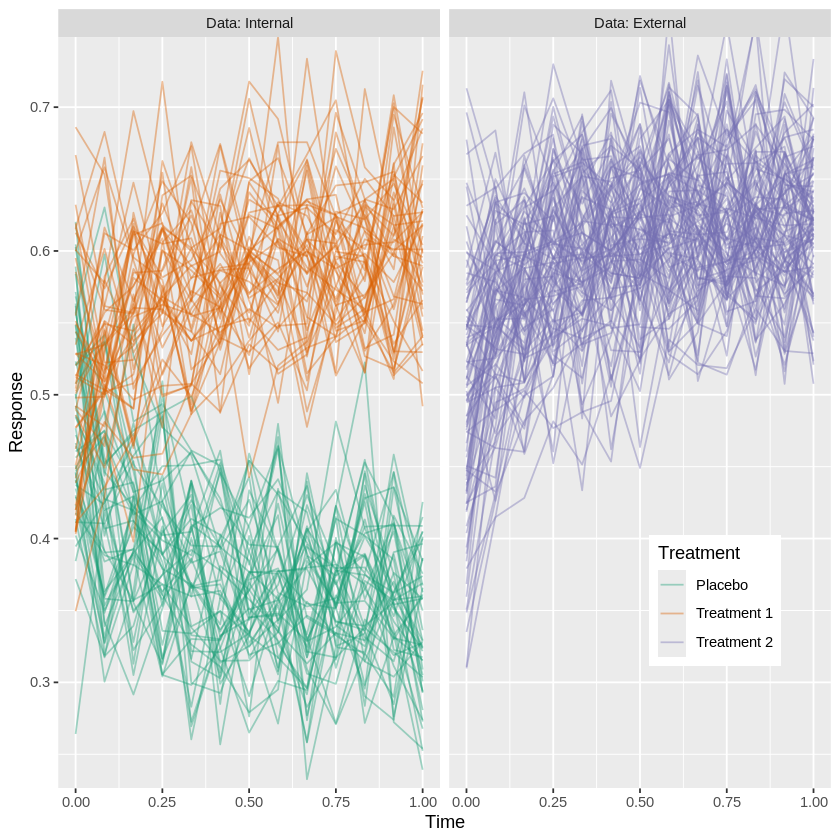

In [57]:
pl_obs

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


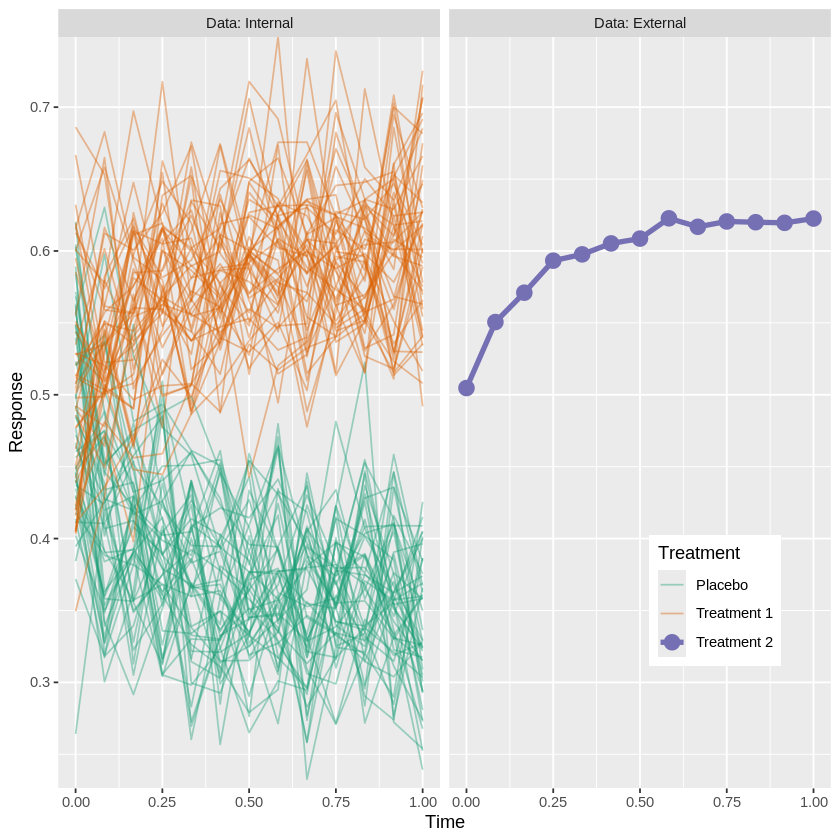

In [58]:
pl_reported <- pl_obs %+% subset(M_obs, prime==0) + geom_point(data=subset(M_obs_aggr, Data=="External"), size=I(4)) + geom_line(data=subset(M_obs_aggr, Data=="External"), size=I(1.5))

pl_reported

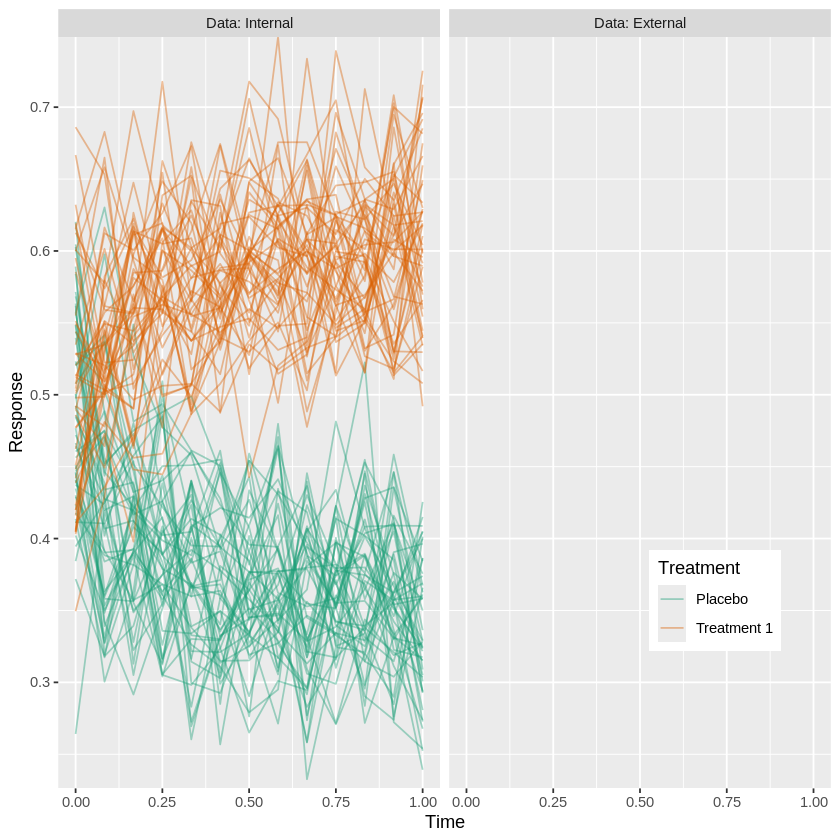

In [59]:
pl_local <- pl_obs %+% subset(M_obs, prime==0)

pl_local

In [60]:
library(ggplot2)

In [61]:
ggsave("pkpd_simulated.pdf", pl_obs, width=7, height=3, device='pdf')
ggsave("pkpd_reported.png", pl_reported, width=7, height=3, device='bmp')
ggsave("pkpd_local.pdf", pl_local, width=7, height=3)

___


In [62]:
model <- stan_model("pkpd_mvn_approxb.stan")

In [63]:
#print(model)

In [64]:
## needed for new approach below
C <- 4 ## max # of chains
xi <- array(rnorm(C*2* 2*J_tilde), dim=c(C, 2, 2*J_tilde))

In [65]:
dim(xi)

[1]    4    2 1000

In [66]:
DRUG <- subj_tot$DRUG
DRUG_prime <- 2

In [67]:
DRUG_prime

[1] 2

In [68]:
## First profile the noisiness of the MVN approximation wrt to
## information about delta
S <- 51
delta_eval <- cbind(delta_1=seq(0,0.4,length=S))


In [69]:
R <- 1e3
delta_quants <- sim_delta(J_tilde=100, R, delta_eval)

In [70]:
dim(delta_quants)

[1] 51  3